Possible improvements:

- Use the crosscheck table to merge DR2 and DR3

- Check the mass: some stars do not have mass information? 


note: adding the last constrint "ap.mass_flame IS NOT NULL" decreases the number of results from 408 to 218



In [1]:
from astroquery.gaia import Gaia
# Gaia.MAIN_GAIA_TABLE = "gaiadr2.gaia_source"  # Select Data Release 2
Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"  # Reselect Data Release 3, default

import numpy as np
import matplotlib.pyplot as plt
from astroquery.simbad import Simbad



In [2]:
from openpyxl import load_workbook

def adjust_column_widths(excel_file):
    """
    Load an Excel workbook, adjust the column widths based on the maximum length of data in each column,
    and save the workbook.

    Parameters:
    - directory: str, the path to the directory containing the Excel file.
    - excel_file: str, the name of the Excel file to be processed.
    """
    # Load the workbook and select the active worksheet
    workbook = load_workbook(excel_file)
    worksheet = workbook.active

    # Adjust the column widths
    for column in worksheet.columns:
        max_length = 0
        column_letter = column[0].column_letter  # Get the column letter
        for cell in column:
            try:
                if len(str(cell.value)) > max_length:
                    max_length = len(str(cell.value))
            except:
                pass
        adjusted_width = (max_length + 2)
        worksheet.column_dimensions[column_letter].width = adjusted_width

    # Save the workbook
    workbook.save(excel_file)




In [3]:
def calculate_habitable_zone(T_eff, L_ratio):
    """
    Calculate the habitable zone boundary based on Kopparapu et al. (2013) Equations 2 & 3,
    using only the "Runaway Greenhouse" limit (Conservative inner boundary).
    
    Parameters:
    T_eff (float): Effective temperature of the star in Kelvin
    
    Returns:
    float: Distance of the habitable zone boundary in AU
    """

    T_sun = 5780  # Effective temperature of the Sun in Kelvin

    # Coefficients for "Runaway Greenhouse" from Table 3 in the paper
    S_eff_sun, a, b, c, d = [1.0512, 1.3242E-4, 1.5418E-8, -7.9895E-12, -1.8328E-15]

    '''
    "Recent Venus": 
    S_eff_sun, a, b, c, d = [1.7753, 1.4316E-4, 2.9875E-9, -7.5702E-12, -1.1635E-15]
    "Runaway Greenhouse": 
    S_eff_sun, a, b, c, d = [1.0512, 1.3242E-4, 1.5418E-8, -7.9895E-12, -1.8328E-15]
    "Moist Greenhouse":
    S_eff_sun, a, b, c, d = [1.0140, 8.1774E-5, 1.7063E-9, -4.3241E-12, -6.6462E-16]
    "Maximum Greenhouse":
    S_eff_sun, a, b, c, d = [0.3438, 5.8942E-5, 1.6558E-9, -3.0045E-12, -5.2983E-16]
    "Early Mars":
    S_eff_sun, a, b, c, d = [0.3179, 5.4513E-5, 1.5313E-9, -2.7786E-12, -4.8997E-16]
    '''

    T_star = T_eff - 5780
    S_eff = S_eff_sun + a*T_star + b*T_star**2 + c*T_star**3 + d*T_star**4
    distance = np.sqrt(L_ratio / S_eff)
    
    return distance

### 1. Qeury Gaia DR2/3 data

names: https://gaia.aip.de/metadata/gaiadr3/gaia_source/

In [4]:
from astroquery.gaia import Gaia
import pandas as pd

#-------------------------------------------------------------
# Define your DR2 query
#-------------------------------------------------------------
# including ap.mass_flame, ap.lum_flame, ap.radius_flame is necessary to get the astrophysical parameters 
# even though we force to use gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
# Without gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id, we would end up with the same clean merged results but without the astrophysical parameters
query_dr2 = """
SELECT gs.source_id, gs.ra, gs.dec, gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag, gs.parallax, gs.teff_val, ap.mass_flame, ap.lum_flame, ap.radius_flame, ap.spectraltype_esphs
FROM gaiadr2.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 9
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 50
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
  AND (gs.phot_bp_mean_mag - gs.phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
"""

# Execute the DR2 query
job_dr2 = Gaia.launch_job(query_dr2)
results_dr2 = job_dr2.get_results()

# Extract DR2 source IDs
dr2_source_ids = tuple(results_dr2['source_id'])

#-------------------------------------------------------------
# Define the crossmatch query using the dr2_neighbourhood table
#-------------------------------------------------------------
crossmatch_query = f"""
SELECT dr2_source_id, dr3_source_id
FROM gaiadr3.dr2_neighbourhood
WHERE dr2_source_id IN {dr2_source_ids}
"""

# Execute the crossmatch query
job_crossmatch = Gaia.launch_job(crossmatch_query)
crossmatch_results = job_crossmatch.get_results()

#-------------------------------------------------------------
# Define your DR3 query
#-------------------------------------------------------------
query_dr3 = """
SELECT gs.source_id, gs.ra, gs.dec, gs.phot_g_mean_mag, gs.phot_bp_mean_mag, gs.phot_rp_mean_mag, gs.bp_rp, gs.parallax, gs.teff_gspphot, ap.mass_flame, ap.lum_flame, ap.radius_flame, ap.spectraltype_esphs
FROM gaiadr3.gaia_source AS gs
JOIN gaiadr3.astrophysical_parameters AS ap ON gs.source_id = ap.source_id
WHERE gs.phot_g_mean_mag < 9
  AND gs.dec BETWEEN -90 AND 60
  AND gs.parallax >= 50
  AND (gs.duplicated_source = 'false' OR gs.duplicated_source IS NULL)
  AND (gs.phot_bp_mean_mag - gs.phot_rp_mean_mag) BETWEEN 0.5 AND 2.0
"""

# Execute the DR3 query
job_dr3 = Gaia.launch_job(query_dr3)
results_dr3 = job_dr3.get_results()

# Convert results to pandas DataFrames for easier merging
df_dr2 = results_dr2.to_pandas()
df_crossmatch = crossmatch_results.to_pandas()
df_dr3 = results_dr3.to_pandas()

# Convert source_id columns to strings
df_dr2['source_id'] = df_dr2['source_id'].astype(str)
df_crossmatch['dr2_source_id'] = df_crossmatch['dr2_source_id'].astype(str)
df_crossmatch['dr3_source_id'] = df_crossmatch['dr3_source_id'].astype(str)
df_dr3['source_id'] = df_dr3['source_id'].astype(str)

#-------------------------------------------------------------
# Merge DR2 and crossmatch results
#-------------------------------------------------------------
merged_dr2_crossmatch = pd.merge(df_dr2, df_crossmatch, left_on='source_id', right_on='dr2_source_id', how='left')

# Merge the above result with DR3 results
merged_results = pd.merge(merged_dr2_crossmatch, df_dr3, left_on='dr3_source_id', right_on='source_id', suffixes=('_dr2', '_dr3'), how='outer')

# Save the results
directory = '../results/'
df_dr2.to_excel(directory+'dr2_results.xlsx', index=False)
df_dr3.to_excel(directory+'dr3_results.xlsx', index=False)
merged_results.to_excel(directory+'merged_results.xlsx', index=False)
adjust_column_widths(directory+'dr2_results.xlsx')
adjust_column_widths(directory+'dr3_results.xlsx')
adjust_column_widths(directory+'merged_results.xlsx')

#-------------------------------------------------------------
# Data Cleaning
#-------------------------------------------------------------

# ***** Step 1: Identify repeated dr2_source_id entries *****
non_empty_dr2 = merged_results[merged_results['dr2_source_id'].notna() & (merged_results['dr2_source_id'] != '')]
repeated_dr2_ids = non_empty_dr2[non_empty_dr2.duplicated('dr2_source_id', keep=False)]['dr2_source_id'].unique()
repeated_entries = merged_results[merged_results['dr2_source_id'].isin(repeated_dr2_ids)]

# Save repeated entries to Excel
repeated_entries.to_excel(directory + 'repeated_entries.xlsx', index=False)
adjust_column_widths(directory + 'repeated_entries.xlsx')

# ***** Step 2: Clean repeated entries *****
def check_dr3_availability(row):
    '''
    Function to check if any DR3 data is available for a given row.
    '''
    dr3_columns = [col for col in row.index if col.endswith('_dr3')]
    return not row[dr3_columns].isnull().all()

def process_repeated_group(group):
    '''
    Function to process a group of repeated entries with the same dr2_source_id.
    '''
    if len(group) != 2:
        # If there are more than 2 entries, keep only the first one
        return group.iloc[1:].index.tolist()  # Return indices of rows to remove
    
    row1, row2 = group.iloc[0], group.iloc[1]
    dr3_available1 = check_dr3_availability(row1)
    dr3_available2 = check_dr3_availability(row2)
    
    if not dr3_available1 and not dr3_available2:
        # If both rows have no DR3 data, remove the second one
        return [group.index[1]]
    elif dr3_available1 and not dr3_available2:
        # If only the first row has DR3 data, remove the second one
        return [group.index[1]]
    elif not dr3_available1 and dr3_available2:
        # If only the second row has DR3 data, remove the first one
        return [group.index[0]]
    else:
        # If both rows have DR3 data, remove the second one
        return [group.index[1]]

# Process repeated entries and get indices of rows to remove
rows_to_remove_indices = repeated_entries.groupby('dr2_source_id').apply(process_repeated_group).sum()

# Get the rows to be removed
rows_to_remove = repeated_entries.loc[rows_to_remove_indices]

# Remove the identified rows from merged_results
clean_merged_results = merged_results[~merged_results.index.isin(rows_to_remove.index)]

# Reset index of clean_merged_results
clean_merged_results = clean_merged_results.reset_index(drop=True)

# Print some information about the results
print(f"Original shape of merged_results: {merged_results.shape}")
print(f"Shape after removing duplicates: {clean_merged_results.shape}")
print(f"Number of rows removed: {merged_results.shape[0] - clean_merged_results.shape[0]}")

# Save clean_merged_results to Excel
clean_merged_results.to_excel(directory + 'clean_merged_results.xlsx', index=False)
adjust_column_widths(directory + 'clean_merged_results.xlsx')

# Save rows_to_remove to Excel
rows_to_remove.to_excel(directory + 'removed_rows.xlsx', index=False)
adjust_column_widths(directory + 'removed_rows.xlsx')

# Check if there are still any duplicates
remaining_duplicates = clean_merged_results[clean_merged_results.duplicated('dr2_source_id', keep=False)]
print(f"\nNumber of remaining duplicate dr2_source_id: {len(remaining_duplicates['dr2_source_id'].unique())}")

if not remaining_duplicates.empty:
    print("\nExample of remaining duplicates:")
    print(remaining_duplicates.groupby('dr2_source_id').first().head())
else:
    print("\nNo remaining duplicates found.")

# ***** Step 3: Consolidate the data *****
# Create a new DataFrame to store the final consolidated data
df = clean_merged_results.copy()

# Function to choose between DR3 and DR2 values
def choose_value(row, col_name):
    dr3_col = f'{col_name}_dr3'
    dr2_col = f'{col_name}_dr2'
    return row[dr3_col] if pd.notnull(row[dr3_col]) else row[dr2_col]

# List of columns to process
columns_to_process = ['ra', 'dec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 'parallax', 'spectraltype_esphs']

# Process each column
for col in columns_to_process:
    df[col] = df.apply(lambda row: choose_value(row, col), axis=1)

# Special handling for temperature
df['T_eff [K]'] = df.apply(lambda row: row['teff_gspphot'] if pd.notnull(row['teff_gspphot']) else row['teff_val'], axis=1)

# For other columns
other_columns = ['mass_flame', 'lum_flame', 'radius_flame', 'spectraltype_esphs']
for col in other_columns:
    df[col] = df.apply(lambda row: choose_value(row, col), axis=1)

# Add bp_rp column from DR3 if available
df['bp_rp'] = df['bp_rp'].fillna(df['phot_bp_mean_mag'] - df['phot_rp_mean_mag'])

# Add the new source_id column
df['source_id'] = df['source_id_dr3'].fillna(df['source_id_dr2'])

# Update the final columns list to include the new source_id column
final_columns = ['source_id', 'source_id_dr2', 'source_id_dr3', 'ra', 'dec', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag', 
                 'bp_rp', 'parallax', 'T_eff [K]', 'mass_flame', 'lum_flame', 'radius_flame', 'spectraltype_esphs']

# Create the final dataframe
df_consolidated = df[final_columns]

# -------------------------------------------------------------
# Add SIMBAD information (HD, GJ, HIP numbers and object type)
# -------------------------------------------------------------
# Customize Simbad to include the HD, GJ, and HIP identifiers and object type
custom_simbad = Simbad()
custom_simbad.add_votable_fields('ids', 'otype')

# Function to get additional information from SIMBAD
def get_simbad_info(source_id):
    result_table = custom_simbad.query_object(f"Gaia DR3 {source_id}")
    hd_numbers = []
    gj_numbers = []
    hip_numbers = []
    object_type = None
    
    if result_table is not None:
        ids = result_table['IDS'][0].split('|')
        hd_numbers = [id.strip() for id in ids if id.startswith('HD')]
        gj_numbers = [id.strip() for id in ids if id.startswith('GJ')]
        hip_numbers = [id.strip() for id in ids if id.startswith('HIP')]
        object_type = result_table['OTYPE'][0]
    
    return {
        'HD Number': ', '.join(hd_numbers) if hd_numbers else None,
        'GJ Number': ', '.join(gj_numbers) if gj_numbers else None,
        'HIP Number': ', '.join(hip_numbers) if hip_numbers else None,
        'Object Type': object_type
    }

# Create a new DataFrame instead of modifying the existing one
new_columns = ['source_id', 'HD Number', 'GJ Number', 'HIP Number', 'Object Type']
df_new = pd.DataFrame(columns=new_columns)

# Populate the new DataFrame
df_new['source_id'] = df_consolidated['source_id_dr3'].fillna(df_consolidated['source_id_dr2'])

# Fetch SIMBAD information for each star
for index, row in df_new.iterrows():
    simbad_info = get_simbad_info(row['source_id'])
    df_new.loc[index, 'HD Number'] = simbad_info['HD Number']
    df_new.loc[index, 'GJ Number'] = simbad_info['GJ Number']
    df_new.loc[index, 'HIP Number'] = simbad_info['HIP Number']
    df_new.loc[index, 'Object Type'] = simbad_info['Object Type']

# Combine the new DataFrame with the original one
df_consolidated = pd.concat([df_consolidated, df_new[['HD Number', 'GJ Number', 'HIP Number', 'Object Type']]], axis=1)

# Update the final columns list to include the new columns
final_columns.extend(['HD Number', 'GJ Number', 'HIP Number', 'Object Type'])

# Create the final dataframe with the updated column list
df_consolidated = df_consolidated[final_columns]

# Rename the columns
df_consolidated = df_consolidated.rename(columns={
    'mass_flame': 'Mass [M_Sun]',
    'lum_flame': 'Luminosity [L_Sun]',
    'radius_flame': 'Radius [R_Sun]',
    'phot_g_mean_mag': 'Phot G Mean Mag',
    'phot_bp_mean_mag': 'Phot BP Mean Mag',
    'phot_rp_mean_mag': 'Phot RP Mean Mag',
    'bp_rp': 'BP-RP',
    'parallax': 'Parallax',
    'ra': 'RA',
    'dec': 'DEC',
    'spectraltype_esphs': 'Spectral Type'
})

# Save the result to a new Excel file
df_consolidated.to_excel(directory + 'consolidated_results.xlsx', index=False)
adjust_column_widths(directory + 'consolidated_results.xlsx')

# Display some statistics
print(f"Total number of stars: {len(df_consolidated)}")
print(f"Number of stars with DR3 source_id: {df_consolidated['source_id_dr3'].notna().sum()}")
print(f"Number of stars with only DR2 source_id: {df_consolidated['source_id_dr3'].isna().sum()}")
print(f"Number of stars with HD Number: {df_consolidated['HD Number'].notna().sum()}")
print(f"Number of stars with GJ Number: {df_consolidated['GJ Number'].notna().sum()}")
print(f"Number of stars with HIP Number: {df_consolidated['HIP Number'].notna().sum()}")


#-------------------------------------------------------------
# Extract data with mass and luminosity information available
#-------------------------------------------------------------
# Filter out stars with missing mass or luminosity information
df_filtered = df_consolidated[(df_consolidated['Mass [M_Sun]'].notna()) & (df_consolidated['Luminosity [L_Sun]'].notna())]

# Remove the entry where the effective temperature is larger than 7000K 
df_filtered = df_filtered[df_filtered['T_eff [K]'] < 7000]

# Save the filtered consolidated data to a new Excel file
df_filtered.to_excel(directory + 'consolidated_results_filtered.xlsx', index=False)
adjust_column_widths(directory + 'consolidated_results_filtered.xlsx')
display(df_filtered)


Original shape of merged_results: (449, 27)
Shape after removing duplicates: (436, 27)
Number of rows removed: 13

Number of remaining duplicate dr2_source_id: 1

Example of remaining duplicates:
Empty DataFrame
Columns: [source_id_dr2, ra_dr2, dec_dr2, phot_g_mean_mag_dr2, phot_bp_mean_mag_dr2, phot_rp_mean_mag_dr2, parallax_dr2, teff_val, mass_flame_dr2, lum_flame_dr2, radius_flame_dr2, spectraltype_esphs_dr2, dr3_source_id, source_id_dr3, ra_dr3, dec_dr3, phot_g_mean_mag_dr3, phot_bp_mean_mag_dr3, phot_rp_mean_mag_dr3, bp_rp, parallax_dr3, teff_gspphot, mass_flame_dr3, lum_flame_dr3, radius_flame_dr3, spectraltype_esphs_dr3]
Index: []

[0 rows x 26 columns]
Total number of stars: 436
Number of stars with DR3 source_id: 408
Number of stars with only DR2 source_id: 28
Number of stars with HD Number: 408
Number of stars with GJ Number: 417
Number of stars with HIP Number: 384


,source_id,source_id_dr2,source_id_dr3,RA,DEC,Phot G Mean Mag,Phot BP Mean Mag,Phot RP Mean Mag,BP-RP,Parallax,T_eff [K],Mass [M_Sun],Luminosity [L_Sun],Radius [R_Sun],Spectral Type,HD Number,GJ Number,HIP Number,Object Type
3,4911306239828325760,4911306239828325760,4911306239828325760,24.950657,-56.196400,5.625487,6.089998,4.995800,1.094198,122.003472,4902.265137,0.772891,0.311397,0.773601,G,HD 10361,GJ 66 A,None,HighPM*
4,4911306239828325632,4911306239828325632,4911306239828325632,24.951317,-56.193251,5.508302,5.956992,4.886207,1.070785,122.108813,5044.240234,0.848425,0.332538,0.755049,G,HD 10360,GJ 66 B,None,HighPM*
8,4503794795019024000,4503794795019024000,4503794795019024000,282.122350,10.743510,7.606561,8.177541,6.885082,1.292459,59.234454,4542.218750,0.747773,0.235664,0.783907,K,HD 174080,GJ 727,HIP 92283,HighPM*
9,4038724053986441856,4038724053986441856,4038724053986441856,271.599414,-36.019747,5.805398,6.107953,5.326963,0.780990,58.429633,5773.397461,0.993722,1.041858,1.020187,F,HD 165185,GJ 702.1,HIP 88694,HighPM*
10,4912580642524184960,4912580642524184960,4912580642524184960,25.623392,-53.741300,5.383109,5.657312,4.946809,0.710503,57.640899,6011.648926,1.074927,1.576709,1.157568,F,HD 10647,GJ 3109,HIP 7978,HighPM*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,4852870701505115904,NaN,4852870701505115904,50.897269,-40.076223,6.703753,7.120555,6.115734,1.004821,56.556967,5304.386230,0.831084,0.500709,0.878492,G,HD 21175,GJ 3222,HIP 15799,HighPM*
408,5274724279107404544,NaN,5274724279107404544,120.628218,-66.021521,6.934041,7.377774,6.329168,1.048605,57.865912,5015.698730,0.813205,0.402590,0.840273,G,HD 67199,GJ 3476,HIP 39342,HighPM*
409,2348830516542653824,NaN,2348830516542653824,12.364012,-23.211912,6.957821,7.347584,6.398603,0.948981,53.052628,5230.245605,0.866382,0.455258,0.821747,G,HD 4747,GJ 36,HIP 3850,SB*
421,272855565763652480,NaN,272855565763652480,69.422784,52.891503,7.952531,8.829921,7.031435,1.798486,100.916060,3760.628174,0.605965,0.079379,0.663517,K,HD 232979,GJ 172,HIP 21553,Eruptive*


In [5]:
combined_df = df_filtered.copy()

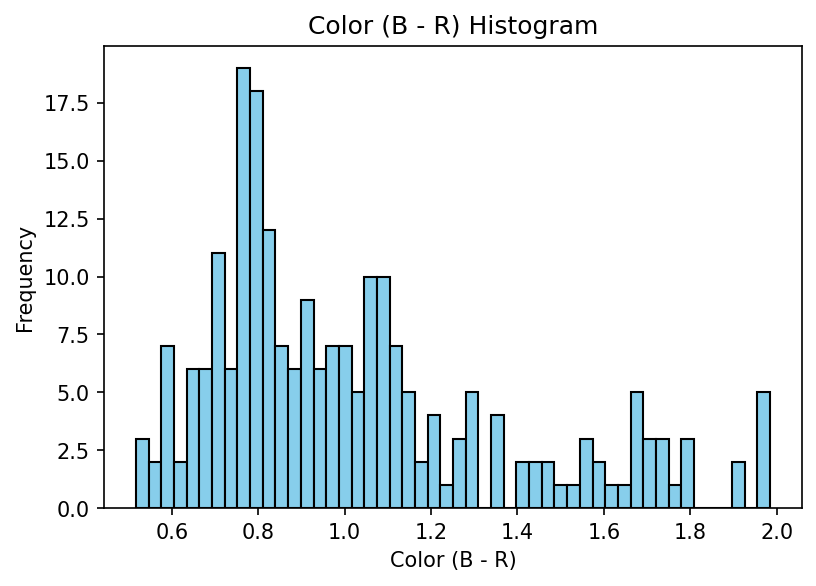

In [6]:
color = combined_df['Phot BP Mean Mag'] - combined_df['Phot RP Mean Mag']


# Create a high-resolution plot
plt.figure(figsize=(6, 4), dpi=150)  # Set the dpi to 300 for high resolution
plt.hist(color, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Color (B - R)')
plt.ylabel('Frequency')
plt.title('Color (B - R) Histogram')
plt.savefig('../figures/color_histogram.png', dpi=300)  # Save the plot as a PNG file
plt.show()

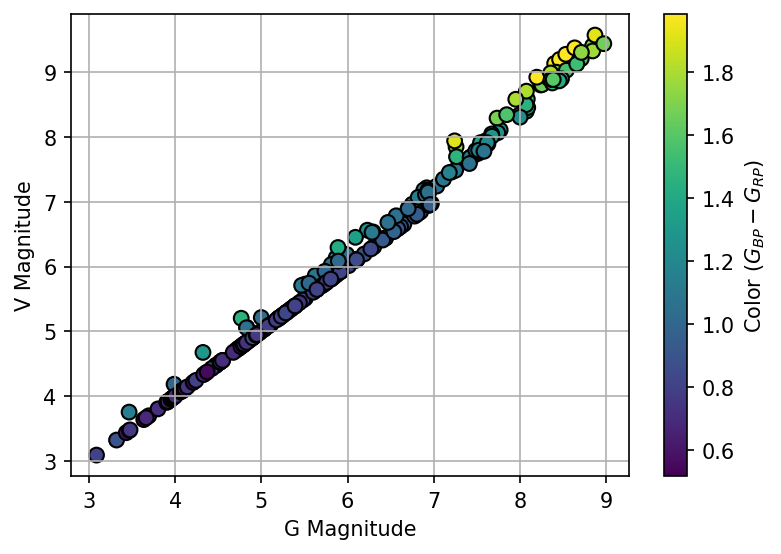

In [7]:

# Assuming 'color' is a column in combined_df or an array of the same length as the DataFrame
# For example, if 'color' is the difference between 'Phot BP Mean Mag' and 'Phot RP Mean Mag'
color = combined_df['Phot BP Mean Mag'] - combined_df['Phot RP Mean Mag']

# Calculate the conversion factor for colors between 1 and 4
conv = 0.20220 + 0.02489 * color

# Use np.where to apply the conversion conditionally
V_mag = np.where((color >= 1) & (color <= 4),
                 combined_df['Phot BP Mean Mag'] - conv,
                 combined_df['Phot G Mean Mag'])

# Create a high-resolution plot
plt.figure(figsize=(6, 4), dpi=150)  # Set the dpi to 300 for high resolution

# Plot the diagram using the color array for point colors
plt.scatter(combined_df['Phot G Mean Mag'], V_mag, c=color, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('G Magnitude')
plt.ylabel('V Magnitude')
# plt.title('Color-Magnitude Diagram')
plt.colorbar(label='Color $(G_{BP} - G_{RP})$')
plt.grid()
plt.savefig('../figures/color_magnitude_diagram.png', dpi=300)
plt.show()


In [8]:
# Insert the 'V_mag' column right after the 'DEC' column
combined_df.insert(combined_df.columns.get_loc('DEC') + 1, 'V_mag', V_mag)

if 'T_eff [K]' in combined_df.columns:

    # Calculate the HZ_limit
    hz_limits = combined_df.apply(lambda row: calculate_habitable_zone(row['T_eff [K]'], row['Luminosity [L_Sun]']), axis=1)
    # Find the index of the 'Radius [R_Sun]' column
    radius_index = combined_df.columns.get_loc('Radius [R_Sun]')
    # Insert the new column after 'Radius [R_Sun]'
    combined_df.insert(radius_index + 1, 'HZ_limit [AU]', hz_limits)
    # Sort the DataFrame by temperature (Teff)
    combined_df = combined_df.sort_values('T_eff [K]')    

# Export the combined DataFrame to an Excel file
combined_excel_file = 'combined_query.xlsx'
output_path = directory + combined_excel_file
combined_df.to_excel(output_path, index=False)

print(f"Combined results saved to {output_path}")
display(combined_df.head())

# Adjust the column widths
adjust_column_widths(output_path)

Combined results saved to ../results/combined_query.xlsx


,source_id,source_id_dr2,source_id_dr3,RA,DEC,V_mag,Phot G Mean Mag,Phot BP Mean Mag,Phot RP Mean Mag,BP-RP,...,T_eff [K],Mass [M_Sun],Luminosity [L_Sun],Radius [R_Sun],HZ_limit [AU],Spectral Type,HD Number,GJ Number,HIP Number,Object Type
89,2683023811628007296,2683023811628007296,2683023811628007296,330.540802,1.398992,9.136045,8.403359,9.387209,7.420015,1.967194,...,3501.576416,0.577452,0.066803,0.702667,0.276365,M,HD 209290,GJ 846,HIP 108782,HighPM*
146,4282578724832056576,4282578724832056576,4282578724832056576,284.499690,5.902697,9.198853,8.460503,9.450294,7.471963,1.978331,...,3560.908936,0.586452,0.069564,0.692835,0.281779,M,HD 176029,GJ 740,HIP 93101,HighPM*
277,6673000841376349696,6673000841376349696,6673000841376349696,303.477391,-45.164731,7.940663,7.242661,8.190446,6.278736,1.911710,...,3588.520508,0.567104,0.061621,0.641908,0.265094,M,HD 191849,GJ 784,HIP 99701,HighPM*
185,4946938113149426944,4946938113149426944,4946938113149426944,38.594380,-43.797657,8.923683,8.196382,9.175138,7.196229,1.978910,...,3611.961182,0.624806,0.091748,0.771405,0.323350,M,HD 16157,GJ 103,HIP 11964,BYDraV*
105,70051608089857536,70051608089857536,70051608089857536,56.585833,26.214633,9.574198,8.871369,9.824131,7.906354,1.917777,...,3655.815186,0.596475,0.073706,0.684450,0.289614,M,HD 23453,GJ 154,HIP 17609,Eruptive*


In [9]:
from rv_prec import calculate_rv_precision

rv_precisions = []

for i in range(len(combined_df)):
    result, rv_precision = calculate_rv_precision(Temp=combined_df.iloc[i]['T_eff [K]'], Vmag=combined_df.iloc[i]['V_mag'])
    rv_precisions.append(rv_precision)

In [10]:
# Find the index of 'HZ_limit [AU]' column
hz_limit_index = combined_df.columns.get_loc('HZ_limit [AU]')

# Insert the rv_precisions to the right of 'HZ_limit [AU]'
combined_df.insert(hz_limit_index + 1, 'RV precision [m/s]', rv_precisions)

In [11]:
merged_df = combined_df.copy()

# Save the updated Excel file
output_path = directory + 'combined_query_with_RV_precision.xlsx'
merged_df.to_excel(output_path, index=False)

# Adjust the column widths
adjust_column_widths(output_path)

### Calculate the HZ mass detection limit

In [12]:
from scipy import optimize

# Constants
G = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2
M_earth = 5.97e24  # Earth mass in kg
M_sun = 1.989e30  # Solar mass in kg
AU = 1.496e11  # 1 AU in meters

def calculate_hz_detection_limit(K, stellar_mass, orbital_radius):
    """
    Calculate the minimum detectable planet mass in the Habitable Zone.
    
    :param K: RV precision in m/s
    :param stellar_mass: Mass of the star in solar masses
    :param orbital_radius: Orbital radius (HZ limit) in AU
    :return: Minimum detectable planet mass in Earth masses or np.nan if calculation fails
    """
    try:
        stellar_mass_kg = stellar_mass * M_sun
        orbital_radius_m = orbital_radius * AU
        
        if K <= 0 or stellar_mass_kg <= 0 or orbital_radius_m <= 0:
            return np.nan
        
        def equation(m_p):
            return K - (G**(1/2) * orbital_radius_m**(-1/2) * m_p * (stellar_mass_kg + m_p)**(-1/2))
        
        # Use numerical method to solve the equation
        planet_mass_kg = optimize.brentq(equation, 0, stellar_mass_kg)
        
        return planet_mass_kg / M_earth
    except:
        return np.nan

# Apply the calculation to each row
merged_df['HZ Detection Limit [Earth Mass]'] = merged_df.apply(
    lambda row: calculate_hz_detection_limit(
        row['RV precision [m/s]'],
        row['Mass [M_Sun]'],
        row['HZ_limit [AU]']
    ),
    axis=1
)

# Print some statistics about the new column
print(merged_df['HZ Detection Limit [Earth Mass]'].describe())

# Count and print the number of NaN values
nan_count = merged_df['HZ Detection Limit [Earth Mass]'].isna().sum()
print(f"Number of NaN values: {nan_count}")

# Reorder the columns to place the new column next to 'Mass'
cols = merged_df.columns.tolist()
mass_index = cols.index('RV precision [m/s]')
cols.insert(mass_index + 1, cols.pop(cols.index('HZ Detection Limit [Earth Mass]')))
merged_df = merged_df[cols]

# Save the updated DataFrame
output_path = directory + 'combined_query_with_mass_detection_limit.xlsx'
merged_df.to_excel(output_path, index=False)

# Adjust the column widths
adjust_column_widths(output_path)

print(f"Updated DataFrame saved to '{output_path}'.")


count    227.000000
mean       2.678016
std        4.413993
min        0.246737
25%        0.991282
50%        1.288627
75%        1.590742
max       24.143052
Name: HZ Detection Limit [Earth Mass], dtype: float64
Number of NaN values: 0
Updated DataFrame saved to '../results/combined_query_with_mass_detection_limit.xlsx'.


### Statistics and plots

In [13]:
print(merged_df.columns.tolist())

['source_id', 'source_id_dr2', 'source_id_dr3', 'RA', 'DEC', 'V_mag', 'Phot G Mean Mag', 'Phot BP Mean Mag', 'Phot RP Mean Mag', 'BP-RP', 'Parallax', 'T_eff [K]', 'Mass [M_Sun]', 'Luminosity [L_Sun]', 'Radius [R_Sun]', 'HZ_limit [AU]', 'RV precision [m/s]', 'HZ Detection Limit [Earth Mass]', 'Spectral Type', 'HD Number', 'GJ Number', 'HIP Number', 'Object Type']


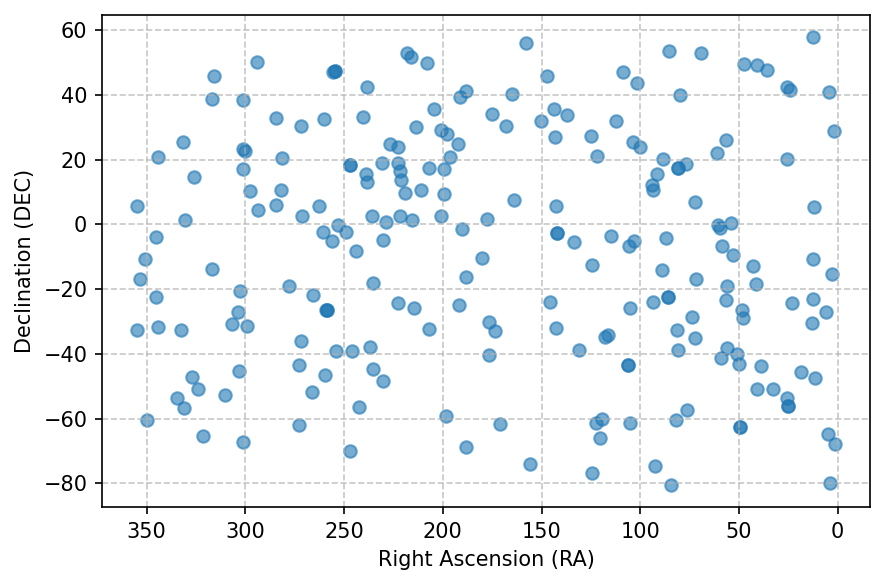

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4), dpi=150)
plt.scatter(merged_df['RA'], merged_df['DEC'], alpha=0.6)
plt.xlabel('Right Ascension (RA)')
plt.ylabel('Declination (DEC)')
plt.grid(True, linestyle='--', alpha=0.7)

# Invert the x-axis to match astronomical convention (RA increases to the left)
plt.gca().invert_xaxis()

plt.tight_layout()
plt.savefig('../figures/ra_dec.png', dpi=300)
plt.show()


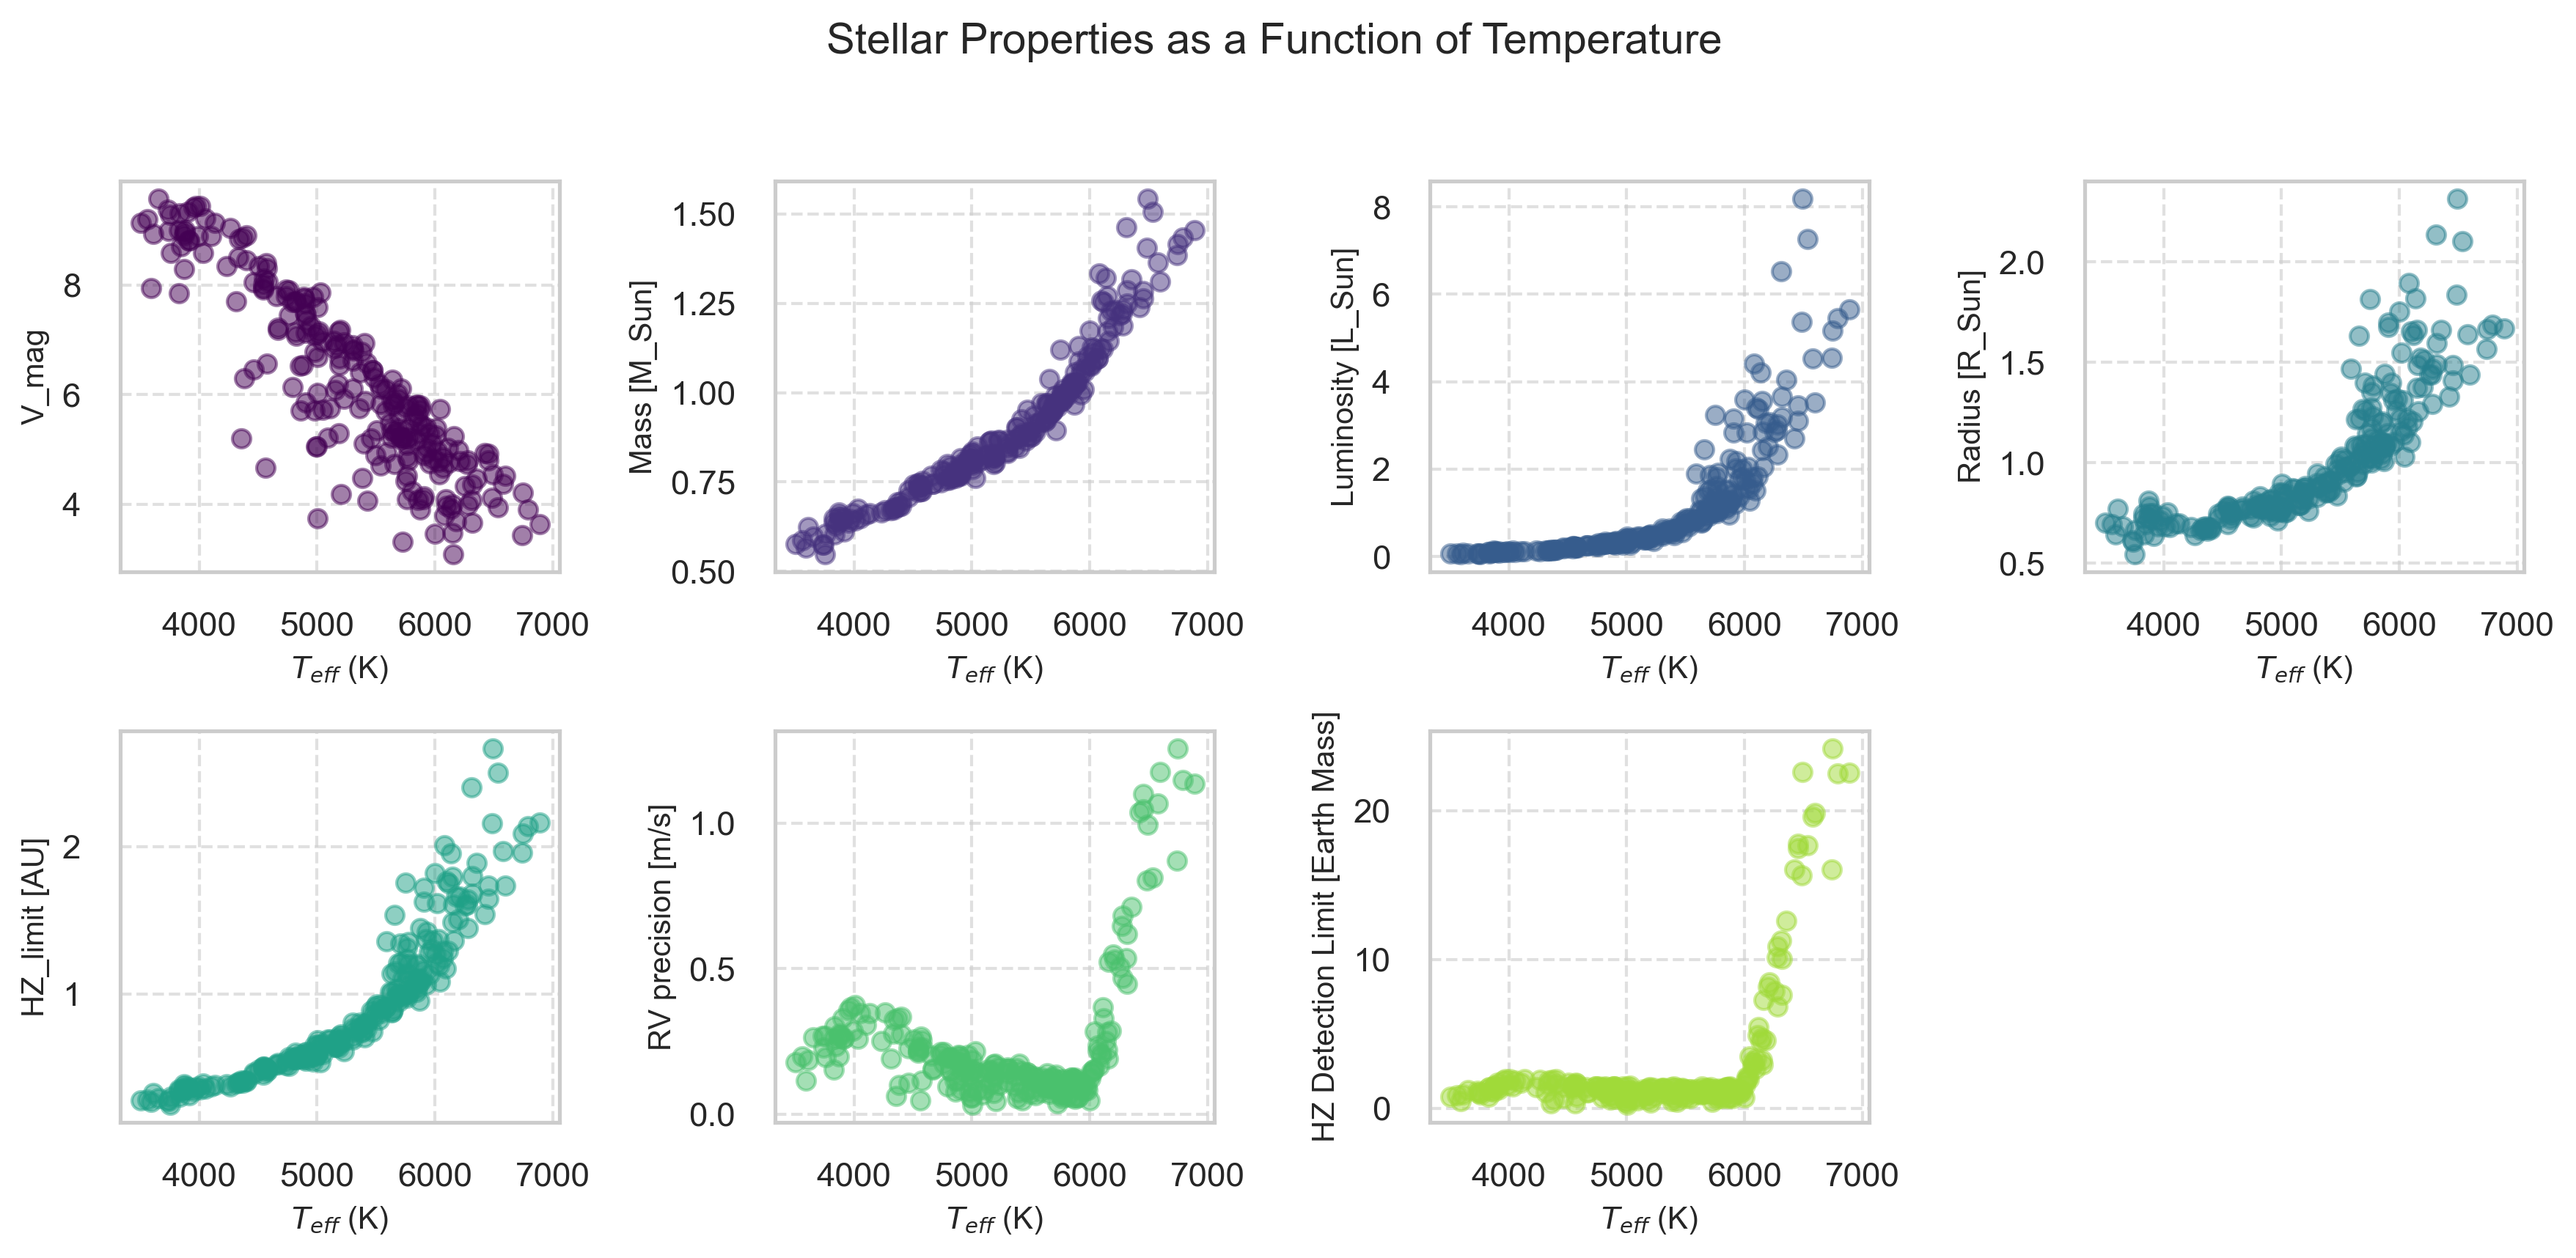

In [20]:
import matplotlib.pyplot as plt

# Create the plot
fig, axs = plt.subplots(2, 4, figsize=(12, 6), dpi=300)

# Flatten the axs array for easier iteration
axs = axs.flatten()

# List of columns to plot
columns = ['V_mag', 'Mass [M_Sun]', 'Luminosity [L_Sun]', 'Radius [R_Sun]', 'HZ_limit [AU]', 
           'RV precision [m/s]', 'HZ Detection Limit [Earth Mass]']

# Define a color palette
colors = plt.cm.viridis(np.linspace(0, 1, len(columns)+1))

# Plot each column
for i, col in enumerate(columns):
    axs[i].scatter(merged_df['T_eff [K]'], merged_df[col], alpha=0.5, color=colors[i])
    axs[i].set_xlabel('$T_{eff}$ (K)', fontsize=10)
    axs[i].set_ylabel(col, fontsize=10)
    axs[i].grid(True, linestyle='--', alpha=0.6)

# Remove the last unused subplot
fig.delaxes(axs[-1])

# Add a main title
fig.suptitle('Stellar Properties as a Function of Temperature', fontsize=14)

# Adjust the layout and display the plot
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('../figures/stellar_properties_vs_temperature.png')
plt.show()


/var/folders/cg/kzyfvcpd4v52gb0tmxfhvrkm0000gp/T/ipykernel_73478/442650974.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


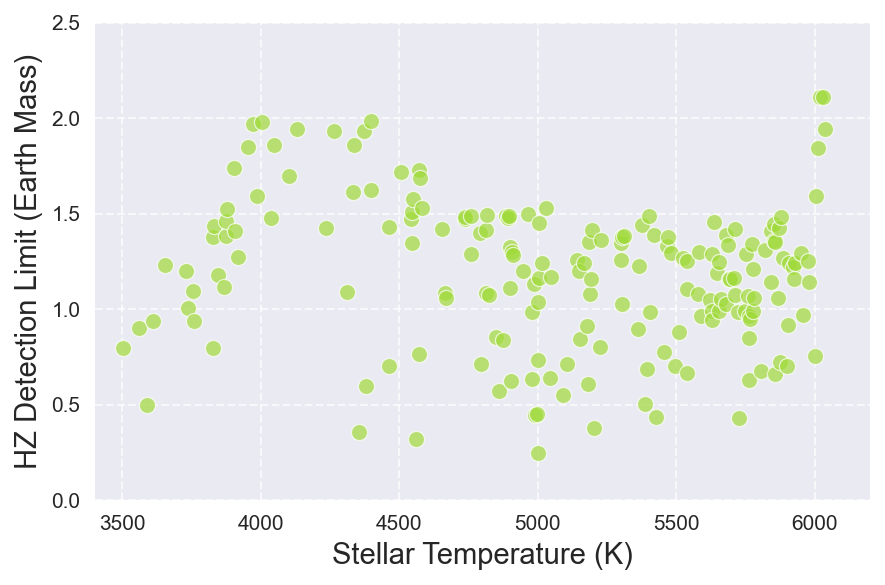

In [16]:
# Set the style for a more modern look
import seaborn as sns
plt.style.use('seaborn')
# sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(6, 4), dpi=150)
# sns.scatterplot(x='T_eff [K]', y='HZ Detection Limit [Earth Mass]', data=merged_df, 
                # color='#1E88E5', alpha=0.7, s=60)
sns.scatterplot(x='T_eff [K]', y='HZ Detection Limit [Earth Mass]', data=merged_df, 
                color=colors[i], alpha=0.7, s=60)


# Customize the plot
plt.xlabel('Stellar Temperature (K)', fontsize=14)
plt.ylabel('HZ Detection Limit (Earth Mass)', fontsize=14)
plt.xlim(min(merged_df['T_eff [K]']) - 100, 6000 + 200)
plt.ylim(0, 2.5)

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Customize tick labels
plt.tick_params(axis='both', which='major')


# Adjust layout and display the plot
plt.tight_layout()
plt.show()

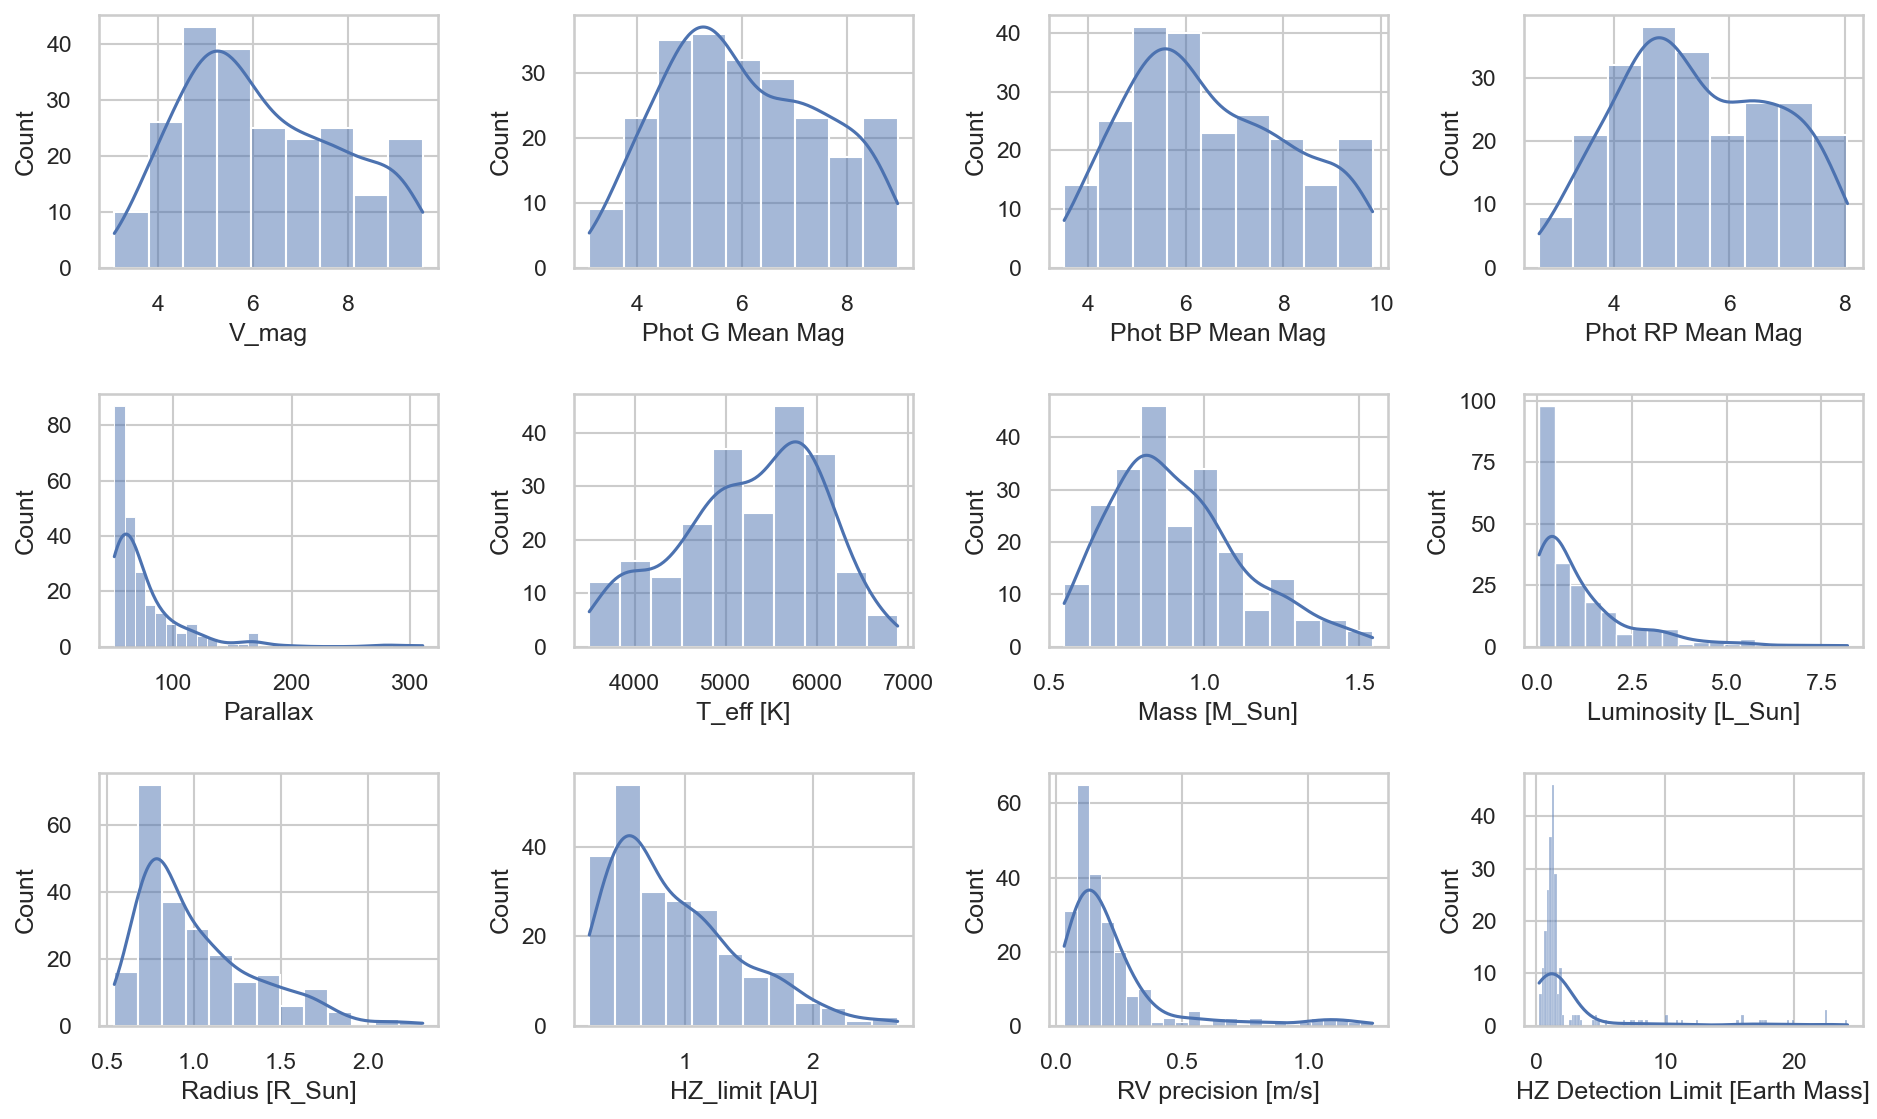

In [17]:
sns.set_theme(style="whitegrid")

# List of columns to plot
columns_to_plot = [
    'V_mag', 'Phot G Mean Mag', 'Phot BP Mean Mag', 'Phot RP Mean Mag',
    'Parallax', 'T_eff [K]', 'Mass [M_Sun]', 'Luminosity [L_Sun]', 'Radius [R_Sun]', 'HZ_limit [AU]', 
           'RV precision [m/s]', 'HZ Detection Limit [Earth Mass]'
]

# Set up the plot
fig, axes = plt.subplots(3, 4, figsize=(12, 8), dpi=150)
# fig.suptitle('Histograms of Stellar Properties', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Create histograms
for i, column in enumerate(columns_to_plot):
    sns.histplot(data=merged_df, x=column, kde=True, ax=axes[i])
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')

# Adjust layout and display
plt.tight_layout()
plt.subplots_adjust(top=0.93, hspace=0.5, wspace=0.4, left=0.01, right=0.99)
plt.savefig('../figures/star_properties_histograms.png')
plt.show()
